# HOTRG (cytnx version)
## Demo-5
* Author: Pochung Chen
* Last update: 2022/5/29
* Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, Σ σ/ς, Τ τ, Υ υ, Φ φ, Χ χ, Ψ ψ, and Ω ω

Two site Hamiltonian: 
$$ \large
  E(s_1, s_2) = -Js_1 s_2
$$

Boltzmann weight on the bond:
$$ \large
  W = e^{-\beta E} = 
  \left[ \begin{array}{cc}
  e^{+\beta J} & e^{-\beta J} \\
  e^{-\beta J} & e^{+\beta J}
  \end{array} \right]
$$

Decompose $W$ as $M M^\dagger$, where
$$ \large
  W = e^{-\beta E} = M M^\dagger,
  M = 
  \left[ \begin{array}{cc}
  +\sqrt{\cosh{\beta J}} & +\sqrt{\sinh{\beta J}} \\
  +\sqrt{\cosh{\beta J}} & -\sqrt{\sinh{\beta J}}
  \end{array} \right]
$$

Numerically, we first perform SVD on $W$ to obtain $M$ and $M^\dagger$:
$$ \large
  W = U S V^\dagger \rightarrow
  M = U \sqrt{S}, M^\dagger = \sqrt{S} U^\dagger.
$$
Note that because $W$ is Hermitian, on has $V=U$.

$$ \large
  T_{ijkl} = \sum_\alpha
  M_{\alpha, i} M_{\alpha, j} M_{\alpha, k} M_{\alpha, l}
$$

$$ \large
  T_c = \frac{2}{\log(1+\sqrt{2})} \approx 2.269.
$$

## Cytnx cheat sheet

* numpy <-> cytnx.tensor <-> cytnx.UniTensor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cytnx

In [2]:
Tc = 2./np.log(1.+np.sqrt(2))
print(Tc)
def ut_print(ut):
    ut.print_diagram()
    print(ut.get_block().numpy())

2.269185314213022


## Constrauct $M$

In [3]:
def M0_(T):
    M0 = np.array([[+np.sqrt(np.cosh(1/T)), +np.sqrt(np.sinh(1/T))],
                   [+np.sqrt(np.cosh(1/T)), -np.sqrt(np.sinh(1/T))]])
    return M0

def M_(T,h):
    W = np.array([[np.exp(1/T), np.exp(-1/T)],
                  [np.exp(-1/T), np.exp(1/T)]])
    W = cytnx.from_numpy(W)
    # S, U, Vd = cytnx.linalg.Svd(W)
    S, U, Vd = W.Svd()
    M = U @ cytnx.linalg.Diag(S.Pow(0.5))
    Md = cytnx.linalg.Diag(S.Pow(0.5)) @ Vd
    M = cytnx.UniTensor(M, rowrank=1)
    M.set_name('M')
    Md = cytnx.UniTensor(Md, rowrank=1)
    Md.set_name('M†')    
    return M, Md

## Construct $T_{bare}$

In [4]:
def delta_():
    delta = cytnx.zeros([2,2,2,2])
    delta[0,0,0,0]= 1.0
    delta[1,1,1,1]= 1.0
    delta = cytnx.UniTensor(delta, rowrank=2)
    delta.set_name('ẟ')
    return delta

def T_bare_(T, h):
    ut_M, ut_Md = M_(T, h)
    ut_delta = delta_()
    Ising_net = cytnx.Network('Networks/Ising_square.net')
    Ising_net.PutUniTensors(['delta', 'M0.d', 'M1.d', 'M2', 'M3'],
                            [ut_delta, ut_Md, ut_Md, ut_M, ut_M])
    T_bare = Ising_net.Launch(optimal=True)
    T_bare.set_name('T_bare')
    return T_bare

def ymerge(Tu, Td):
    ymerge_net = cytnx.Network('Networks/merge_two_y.net')
    ymerge_net.PutUniTensors(['Tu', 'Td'], [Tu, Td])
    Tud = ymerge_net.Launch(optimal=True)
    Tud.combineBonds([1,2])
    Tud.combineBonds([3,4])
    return Tud

def ymerge_nc(Tu, Td):
    ymerge_net = cytnx.Network('Networks/merge_two_y.net')
    ymerge_net.PutUniTensors(['Tu', 'Td'], [Tu, Td])
    Tud = ymerge_net.Launch(optimal=True)
    # Tud.combineBonds([1,2])
    # Tud.combineBonds([3,4])
    return Tud
    
# def ymerge_TM(Tu, Td):
#     ymerge_net_TM = cytnx.Network('Networks/merge_two_y_trace.net')
#     ymerge_net_TM.PutUniTensors(['Tu', 'Td'], [Tu, Td])
#     TMud = ymerge_net_TM.Launch(optimal=True)
#     TMud.combineBonds([1,2])
#     TMud.combineBonds([3,4])
#     TMud = TMud.get_block()
#     return TMud

def xmerge(Tl, Tr):
    xmerge_net = cytnx.Network('Networks/merge_two_x.net')
    xmerge_net.PutUniTensors(['Tl', 'Tr'], [Tl, Tr])
    Tlr = xmerge_net.Launch(optimal=True)
    Tlr.combineBonds([0,1])
    Tlr.combineBonds([4,5])
    return Tlr

# def xmerge_TM(Tl, Tr):
#     xmerge_net_TM = cytnx.Network('Networks/merge_two_x_trace.net')
#     xmerge_net_TM.PutUniTensors(['Tl', 'Tr'], [Tl, Tr])
#     TMlr = xmerge_net_TM.Launch(optimal=True)
#     # TMlr.print_diagram()
#     # TMlr.combineBonds([0,1])
#     # TMlr.combineBonds([4,5])
#     return TMlr

def T_to_TM(T):
    trace_net = cytnx.Network('Networks/trace_y.net')
    dim = T.shape()[0]
    trace_net.PutUniTensors(['T', 'Id'], [T, cytnx.UniTensor(cytnx.eye(dim), rowrank=1)])
    TM = trace_net.Launch(optimal=True)
    TM = TM.get_block()
    return TM

## Transfer Matrix

* TM$[(L_x, L_y)]$ = Transfer Matrix of $L_x$ columns, each column has $L_y$ sites. 
* $\lambda_i(L_x, L_y)$ = Eigenvalues of TM$[(L_x, L_y)]$.
* $E_i(Lx, Ly) = -\ln \lambda_i(L_x, L_y)$.
* $\lambda_i(L_y, L_y)=\lambda_i(1, L_y)^{L_x}$
* $E_i(L_y, L_y) = L_x E_i(1, L_y)$

Correlation length $\xi$ for an infinite strip (in x-direction) of width $L_y$
$$ \large
  \xi(L_y)=\frac{1}{E_1(1,L_y)-E_0(1,L_y)}.
$$

$$ \large
  \frac{\xi(L_y)}{L_y}
  =\frac{1}{[E_1(1,L_y)-E_0(1,L_y)]L_y}
  =\frac{L_x}{[E_1(L_x,L_y)-E_0(L_x,L_y)]L_y}.
$$

For $L_x = L_y$
$$ \large
  \frac{\xi(L)}{L}
  =\frac{1}{E_1(L_x,L_y)-E_0(L_x,L_y)}.
$$


## Merge

Linear growth in y-direction:
* T[(1, Ly)], T[(1, 1)] -->ymerge--> T[(1, Ly+1)] 

Power law growth in both directionx:
* T[(1, 1)], T[(1, 1)] -->ymerge--> T[(1, 2)]
* T[(1, 2)], T[(1, 2)] -->xmerge--> T[(2, 2)]
* T[(2, 2)], T[(2, 2)] -->ymerge--> T[(2, 4)]
* T[(2, 4)], T[(2, 4)] -->xmerge--> T[(4, 4)]

## Single temperature, various sizes (power law growth)

In [5]:
T = {}
TM = {}
λ = {}
E = {}
temp = 1.0
h = 0.0

In [6]:
##### T[(1,1)]
T[(1,1)] = T_bare_(temp, h)

T[(1,1)].set_name('T[(1,1)]')
T[(1,1)].print_diagram()

-----------------------
tensor Name : T[(1,1)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 2  
           |             |     
     1 ____| 2         2 |____ 3  
           \             /     
            -------------      


In [7]:
##### T[(1,2)]
T[(1,2)] = ymerge(T[(1,1)], T[(1,1)])
TM[(1,2)] = T_to_TM(T[(1,2)])
λ[(1,2)], _ = cytnx.linalg.Eigh(TM[(1,2)])
λ[(1,2)] = λ[(1,2)].numpy()[::-1]
E[(1,2)] = -np.log(λ[(1,2)])
print('E[(1,2)]/1/2=', E[(1,2)][:4]/1/2)

T[(1,2)].set_name('T[(1,2)]')
T[(1,2)].print_diagram()

E[(1,2)]/1/2= [-2.00973273 -1.99075728  0.00924272  0.02821817]
-----------------------
tensor Name : T[(1,2)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 3  
           |             |     
     1 ____| 4         2 |____ 5  
           \             /     
            -------------      


In [8]:
##### T[(2,2)]
T[(2,2)] = xmerge(T[(1,2)], T[(1,2)])
TM[(2,2)] = T_to_TM(T[(2,2)])
λ[(2,2)], _ = cytnx.linalg.Eigh(TM[(2,2)])
λ[(2,2)] = λ[(2,2)].numpy()[::-1]
E[(2,2)] = -np.log(λ[(2,2)])
print('E[(2,2)]/2/2=', E[(2,2)][:4]/2/2)

T[(2,2)].set_name('T[(2,2)]')
T[(2,2)].print_diagram()

E[(2,2)]/2/2= [-2.00973273 -1.99075728  0.00924272  0.02821817]
-----------------------
tensor Name : T[(2,2)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4         4 |____ 3  
           |             |     
     2 ____| 4         4 |____ 4  
           \             /     
            -------------      


In [9]:
##### T[(2,4)]
T[(2,4)] = ymerge(T[(2,2)], T[(2,2)])
TM[(2,4)] = T_to_TM(T[(2,4)])
λ[(2,4)], _ = cytnx.linalg.Eigh(TM[(2,4)])
λ[(2,4)] = λ[(2,4)].numpy()[::-1]
E[(2,4)] = -np.log(λ[(2,4)])
print('E[(2,4)]/2/4=', E[(2,4)][:4]/2/4)

T[(2,4)].set_name('T[(2,4)]')
T[(2,4)].print_diagram()

E[(2,4)]/2/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]
-----------------------
tensor Name : T[(2,4)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4        16 |____ 3  
           |             |     
     1 ____| 16        4 |____ 5  
           \             /     
            -------------      


In [10]:
##### T[(4,4)]
T[(4,4)] = xmerge(T[(2,4)], T[(2,4)])
TM[(4,4)] = T_to_TM(T[(4,4)])
λ[(4,4)], _ = cytnx.linalg.Eigh(TM[(4,4)])
λ[(4,4)] = λ[(4,4)].numpy()[::-1]
E[(4,4)] = -np.log(λ[(4,4)])
print('E[(4,4)]/4/4=', E[(4,4)][:4]/4/4)

T[(4,4)].set_name('T[(4,4)]')
T[(4,4)].print_diagram()

E[(4,4)]/4/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]
-----------------------
tensor Name : T[(4,4)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 3  
           |             |     
     2 ____| 16       16 |____ 4  
           \             /     
            -------------      


## Approximation
* 4x4=16 --> 10

In [13]:
update_pure_net = cytnx.Network('Networks/update_pure.net')
update_pure_net.PutUniTensors(['Tu', 'Td', 'Tu.d', 'Td.d'], [T[(2,2)], T[(2,2)], T[(2,2)].Dagger(), T[(2,2)].Dagger()])
T[(2,2)].print_diagram()

Θ = update_pure_net.Launch(optimal=True)
Θ.set_name('Θ')
Θ.print_diagram()

-----------------------
tensor Name : T[(2,2)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4         4 |____ 3  
           |             |     
     2 ____| 4         4 |____ 4  
           \             /     
            -------------      
-----------------------
tensor Name : Θ
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4         4 |____ 2  
           |             |     
     1 ____| 4         4 |____ 3  
           \             /     
            -------------      


In [33]:
dcut = 10
print([dcut, np.prod(Θ.shape()[:2]), np.prod(Θ.shape()[2:])])
dc = np.min([dcut, np.prod(Θ.shape()[:2]), np.prod(Θ.shape()[2:])])
print(dc)

[10, 16, 16]
10


In [34]:
S, U, _ = cytnx.linalg.Svd_truncate(Θ, keepdim=dc)
U.print_diagram()
print(S)
update_net = cytnx.Network('Networks/update_two_y.net')
update_net.PutUniTensors(['Tu','Td','UT','U'],[T[(2,2)],T[(2,2)],U.Dagger(),U])
T[(2,4,dc)] = update_net.Launch(optimal=True)
T[(2,4,dc)].print_diagram()

-----------------------
tensor Name : 
tensor Rank : 3
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4        10 |____ -1 
           |             |     
     1 ____| 4           |        
           \             /     
            -------------      
-------- start of print ---------
Tensor name: 
Tensor name: 
is_diag    : True
contiguous : True

Total elem: 10
type  : Double (Float64)
cytnx device: CPU
Shape : (10)
[7.95001e+13 7.94234e+13 8.15900e+10 8.15114e+10 4.92332e+10 4.91857e+10 1.60773e+10 1.60618e+10 5.05275e+07 5.04788e+07 ]




-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4        10 |____ 2  
           |             |     
     1 ____| 10        4 |____ 3  
           \             /     
            ---------

In [35]:
##### T[(4,4)]
T[(4,4,dc)] = xmerge(T[(2,4,dc)], T[(2,4,dc)])
TM[(4,4,dc)] = T_to_TM(T[(4,4)])
λ[(4,4)], _ = cytnx.linalg.Eigh(TM[(4,4)])
λ[(4,4)] = λ[(4,4)].numpy()[::-1]
E[(4,4)] = -np.log(λ[(4,4)])
print('E[(4,4,dc)]/4/4=', E[(4,4)][:4]/4/4)

T[(4,4,dc)].set_name('T[(4,4,{})]'.format(dc))
T[(4,4,dc)].print_diagram()

E[(4,4,dc)]/4/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]
-----------------------
tensor Name : T[(4,4,10)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       10 |____ 3  
           |             |     
     2 ____| 10       16 |____ 4  
           \             /     
            -------------      


In [36]:
TT = ymerge_nc(T[(2,2)], T[(2,2)])
TT.print_diagram()
# TM[(2,4)] = T_to_TM(T[(2,4)])
# λ[(2,4)], _ = cytnx.linalg.Eigh(TM[(2,4)])
# λ[(2,4)] = λ[(2,4)].numpy()[::-1]
# E[(2,4)] = -np.log(λ[(2,4)])
# print('E[(2,4)]/2/4=', E[(2,4)][:4]/2/4)

-----------------------
tensor Name : 
tensor Rank : 6
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4         4 |____ 3  
           |             |     
     1 ____| 4         4 |____ 4  
           |             |     
     2 ____| 4         4 |____ 5  
           \             /     
            -------------      


In [37]:
TT.permute_([1,2,0,3,4,5],rowrank=2)
TT.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 6
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         4 |____ 0  
           |             |     
     2 ____| 4         4 |____ 3  
           |             |     
           |           4 |____ 4  
           |             |     
           |           4 |____ 5  
           \             /     
            -------------      


In [38]:
S, U, _ = cytnx.linalg.Svd_truncate(TT, keepdim=dc)
U.print_diagram()
print(S*S)

-----------------------
tensor Name : 
tensor Rank : 3
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4        10 |____ -1 
           |             |     
     2 ____| 4           |        
           \             /     
            -------------      
-------- start of print ---------
Tensor name: 
Tensor name: 
is_diag    : True
contiguous : True

Total elem: 10
type  : Double (Float64)
cytnx device: CPU
Shape : (10)
[7.95001e+13 7.94234e+13 8.15900e+10 8.15114e+10 4.92332e+10 4.91857e+10 1.60773e+10 1.60618e+10 5.05275e+07 5.04788e+07 ]






In [39]:
update_net = cytnx.Network('Networks/update_two_y.net')
update_net.PutUniTensors(['Tu','Td','UT','U'],[T[(2,2)],T[(2,2)],U.Dagger(),U])
T[(2,4,dc)] = update_net.Launch(optimal=True)
T[(2,4,dc)].print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 4        10 |____ 2  
           |             |     
     1 ____| 10        4 |____ 3  
           \             /     
            -------------      


In [40]:
##### T[(4,4)]
T[(4,4,dc)] = xmerge(T[(2,4,dc)], T[(2,4,dc)])
TM[(4,4,dc)] = T_to_TM(T[(4,4)])
λ[(4,4)], _ = cytnx.linalg.Eigh(TM[(4,4)])
λ[(4,4)] = λ[(4,4)].numpy()[::-1]
E[(4,4)] = -np.log(λ[(4,4)])
print('E[(4,4,dc)]/4/4=', E[(4,4)][:4]/4/4)

T[(4,4,dc)].set_name('T[(4,4,{})]'.format(dc))
T[(4,4,dc)].print_diagram()

E[(4,4,dc)]/4/4= [-2.0004515  -2.000245   -1.08572752 -1.05884264]
-----------------------
tensor Name : T[(4,4,10)]
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       10 |____ 3  
           |             |     
     2 ____| 10       16 |____ 4  
           \             /     
            -------------      


## Various temperatures, various sizes (power law growth)

In [6]:
λ = {}
E = {}
λ0 = {}
λ1 = {}
E0 = {}
E1 = {}

In [7]:
temp_range = np.linspace(2.2, 2.4, 41)

for L in [1,2,4]:
    λ0[(L, L)] = np.zeros_like(temp_range)
    λ1[(L, L)] = np.zeros_like(temp_range)
    E0[(L, L)] = np.zeros_like(temp_range)
    E1[(L, L)] = np.zeros_like(temp_range)

for i, temp in enumerate(temp_range):
    T = {}
    TM = {}
    T[(1,1)] = T_bare_(temp, h)
    
    for L in [1,2]:
        # print((2*L, 2*L))
        T[(L, 2*L)] = ymerge(T[(L, L)], T[(L, L)])
        T[(2*L, 2*L)] = xmerge(T[(L, 2*L)], T[(L, 2*L)])
        TM[(2*L, 2*L)] =T_to_TM(T[(2*L, 2*L)])
        λ[(2*L, 2*L)], _ = cytnx.linalg.Eigh(TM[(2*L, 2*L)])
        λ[(2*L, 2*L)] = λ[(2*L, 2*L)].numpy()[::-1]
        E[(2*L, 2*L)] = -np.log(λ[(2*L, 2*L)])
        λ0[(2*L, 2*L)][i] = λ[(2*L, 2*L)][0]
        λ1[(2*L, 2*L)][i] = λ[(2*L, 2*L)][1]
        E0[(2*L, 2*L)][i] = E[(2*L, 2*L)][0]
        E1[(2*L, 2*L)][i] = E[(2*L, 2*L)][1]

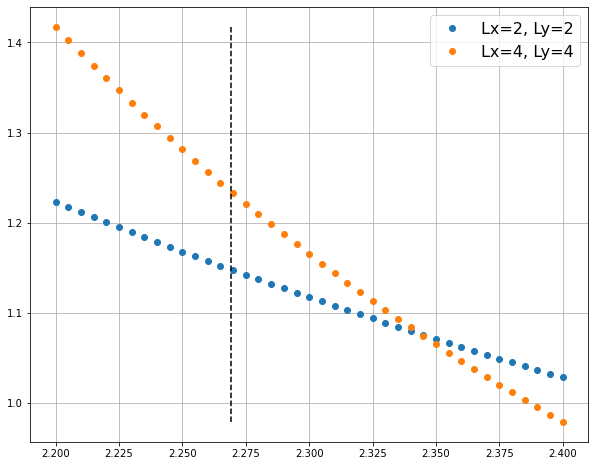

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

for L in [2,4]:
    ax.plot(temp_range, 1/((E1[(L,L)]-E0[(L,L)])), 'o', label='Lx={}, Ly={}'.format(L, L))

ax.plot([Tc, Tc], [np.min(1/((E1[(L,L)]-E0[(L,L)]))), np.max(1/((E1[(L,L)]-E0[(L,L)])))],'k--')
# ax.set_xlim(2.25, 2.30)
# ax.set_ylim(1.15, 1.35)
ax.legend(fontsize=16)
ax.grid()

In [9]:
temp_range = np.linspace(2.2, 2.4, 41)
temp_range = [Tc]

for L in [1,2,4]:
    λ0[(L, L)] = np.zeros_like(temp_range)
    λ1[(L, L)] = np.zeros_like(temp_range)
    E0[(L, L)] = np.zeros_like(temp_range)
    E1[(L, L)] = np.zeros_like(temp_range)

for i, temp in enumerate(temp_range):
    T = {}
    TM = {}
    T[(1,1)] = T_bare_(temp, h)
    
    for L in [1,2]:
        # print((2*L, 2*L))
        T[(L, 2*L)] = ymerge(T[(L, L)], T[(L, L)])
        T[(2*L, 2*L)] = xmerge(T[(L, 2*L)], T[(L, 2*L)])
        TM[(2*L, 2*L)] =T_to_TM(T[(2*L, 2*L)])
        λ[(2*L, 2*L)], _ = cytnx.linalg.Eigh(TM[(2*L, 2*L)])
        λ[(2*L, 2*L)] = λ[(2*L, 2*L)].numpy()[::-1]
        E[(2*L, 2*L)] = -np.log(λ[(2*L, 2*L)])
        λ0[(2*L, 2*L)][i] = λ[(2*L, 2*L)][0]
        λ1[(2*L, 2*L)][i] = λ[(2*L, 2*L)][1]
        E0[(2*L, 2*L)][i] = E[(2*L, 2*L)][0]
        E1[(2*L, 2*L)][i] = E[(2*L, 2*L)][1]